# Pipeline for High-z Radio Galaxies 03: AGN/Galaxy regression

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field using regression.  

Sources are all elements detected in the CatWISE2020 catalogue.  Classification will be done  
with the output of the first classification model over the full dataset.  Then, highly confident  
predictions and confirmed sources will be used in a new regression model that will try to  
predict the probability/score of being either a galaxy or an AGN.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [8]:
def mad(true_class, pred_class, **kwargs):
    med = np.nanmedian(np.abs(true_class - pred_class))
    return med

***

## Reading data

In [9]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [10]:
save_plot_flag  = True
save_model_flag = False
load_model_flag = True

In [11]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [12]:
mqc_version = '7_4d'  # '7_2'

In [13]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [14]:
features_2_discard = ['W1mag', 'W2mag', 'objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [15]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [16]:
# full_catalog_df.describe()

## Random seed

In [17]:
seed = 42

#### Select confirmed galaxies and AGN, and a fraction (or all) unknown sources

In [18]:
confirmed_indices = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_AGN'] == 1)].index
unknown_indices   = full_catalog_df.drop(index=confirmed_indices).index

##### Temporary: Select a smaller sample size for testing.

In [19]:
# selected_indices = full_catalog_df.loc[unknown_indices].sample(n=2*len(confirmed_indices), random_state=seed).index
selected_indices = unknown_indices
final_indices    = confirmed_indices.union(selected_indices)

In [20]:
full_catalog_df = full_catalog_df.loc[final_indices]

Create target

$0$ for galaxies and $1$ for AGN

In [21]:
full_catalog_df['class'] = full_catalog_df.loc[:, 'is_AGN'].copy()

#### Load previous model to create labels for unknown sources.

In [22]:
# if load_model_flag:
AGN_gal_clf = pyc.load_model('models/classification_AGN_galaxy_apr_20_2022')

Transformation Pipeline and Model Successfully Loaded


In [23]:
AGN_pred_threshold = 0.5
new_labels_train   = pyc.predict_model(AGN_gal_clf,\
                    data=full_catalog_df.loc[selected_indices],\
                    probability_threshold=AGN_pred_threshold, raw_score=True).loc[:, 'Score_1']

In [24]:
full_catalog_df.loc[selected_indices, 'class'] = new_labels_train

In [25]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_unk = len(full_catalog_df) - n_is_AGN - n_is_gal
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements,\n' +\
         f'{n_is_AGN} of them are marked as AGN, and {n_is_gal} are identified as galaxies\n' +\
         f'{n_is_unk} have no previous (confirmed) label.')

In this dataset, with 6729647 elements,
30395 of them are marked as AGN, and 55153 are identified as galaxies
6644099 have no previous (confirmed) label.


Remove intermediate targets

In [26]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal'])

---

In [27]:
gal_threshold = 0.05
AGN_threshold = 0.95

Histogram of new classes (and their probabilities)

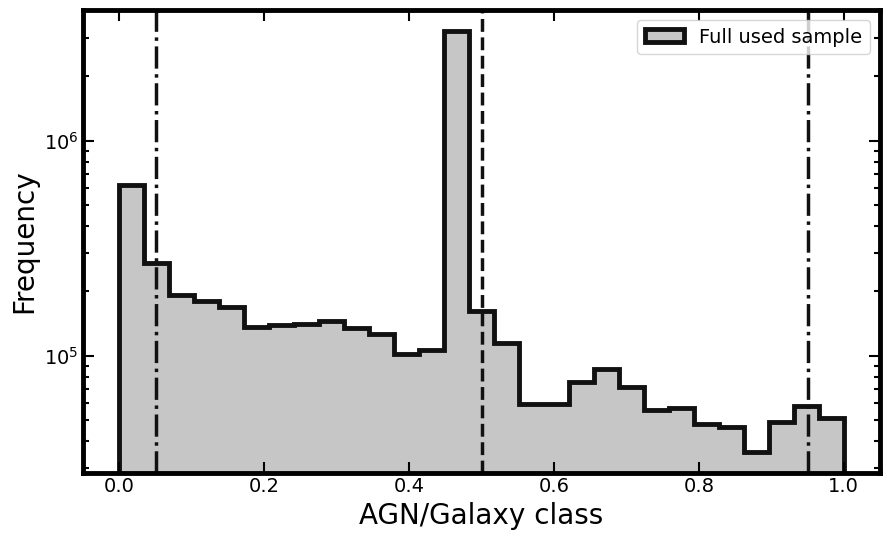

In [28]:
fig             = plt.figure(figsize=(9,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'class'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'class'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(full_catalog_df.loc[:, 'class'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Full used sample')

ax1.axvline(x=0.5,           ls='--', c='k', lw=2.5)
ax1.axvline(x=gal_threshold, ls='-.', c='k', lw=2.5)
ax1.axvline(x=AGN_threshold, ls='-.', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
# if save_plot_flag:
#     plt.savefig('plots/classes_AGN_galaxy_plus_predictions.pdf', bbox_inches='tight')
fig.tight_layout()

It is possible to select only sources that are very close to be confirmed.  
Training could be done with these sources only.

In [29]:
conf_gal = np.sum((full_catalog_df.loc[:, 'class'] == 0.0))

In [30]:
conf_AGN = np.sum((full_catalog_df.loc[:, 'class'] == 1.0))

In [31]:
upgrad_AGN = np.sum((full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00))

In [32]:
upgrad_gal = np.sum((full_catalog_df.loc[:, 'class'] > 0.00) & (full_catalog_df.loc[:, 'class'] < gal_threshold))

In [33]:
print(f'{conf_gal + conf_AGN:,}')

85,548


In [34]:
print(f'{upgrad_gal + upgrad_AGN:,}')

746,816


In [35]:
print(f'{conf_gal + upgrad_gal:,}')

753,431


In [36]:
print(f'{conf_AGN + upgrad_AGN:,}')

78,933


In [37]:
print(f'{conf_gal + conf_AGN + upgrad_gal + upgrad_AGN:,}')

832,364


In [38]:
print(f"{np.sum((full_catalog_df.loc[:, 'class'] > 0.0) & (full_catalog_df.loc[:, 'class'] < 1.0)):,}")

6,644,099


In [39]:
filter_upgrade_gal = (full_catalog_df.loc[:, 'class'] > 0.00) & (full_catalog_df.loc[:, 'class'] < gal_threshold)
filter_upgrade_AGN = (full_catalog_df.loc[:, 'class'] > AGN_threshold) & (full_catalog_df.loc[:, 'class'] < 1.00)

In [40]:
# full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_gal, 0)
# full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].mask(filter_upgrade_AGN, 1)

In [41]:
# full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1) |\
#                                       filter_upgrade_gal | filter_upgrade_AGN]

In [42]:
# full_catalog_df.loc[:, 'class'] = full_catalog_df.loc[:, 'class'].astype(int)

---

Load validation set indices from previous model.

In [43]:
old_validation_idx = pd.Index(np.loadtxt(fname='idx_validation_01.txt', dtype=np.int32))

In [44]:
remaining_idx      = full_catalog_df.drop(index=old_validation_idx).index

In [45]:
needed_val         = np.ceil(len(full_catalog_df) * 0.2).astype(int)

In [46]:
remaining_val_size = needed_val - len(old_validation_idx)

## Split data: Test, Train, Validation

In [47]:
_, temp_val_df = train_test_split(full_catalog_df.drop(index=old_validation_idx), test_size=remaining_val_size,\
                                  random_state=seed, stratify=None)
temp_val_idx   = temp_val_df.index
new_val_idx    = old_validation_idx.union(temp_val_idx)

validation_df  = full_catalog_df.loc[new_val_idx]
train_test_df  = full_catalog_df.drop(index=new_val_idx)

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Unseen Data For Validation: {validation_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (6729647, 39)
Data for Modeling (Train and Test): (5383717, 39)
Unseen Data For Validation: (1345930, 39)
----------------------------------------


Save indices of sources in validation sub-set for future steps.

In [48]:
# val_idx = new_val_idx.to_numpy()
# np.savetxt(fname='idx_validation_02.txt', X=val_idx, header='Indices from second AGN training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [49]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [50]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [51]:
rsd_vals

w1_w2       297.002761
r_i         156.150228
g_r         151.003560
g_i         108.997276
i_z          89.909671
z_y          86.754900
band_num     63.638094
class        55.051763
J_H          22.464530
H_K          21.513474
w2_w3        17.492513
FUVmag        8.097891
imag          7.818320
zmag          7.575312
i/K           7.550355
W2mproPM      7.215621
rmag          7.139579
w1/w4         6.273324
gmag          6.113229
z/W1          6.031682
r/H           5.742295
w3_w4         5.702286
ymag          5.670218
w1/w3         5.539109
Jmag          5.533106
y/W2          5.380681
FUV/K         5.202941
g/J           4.648971
Hmag          4.569893
W4mag         4.517869
i/y           4.343032
r/z           4.079542
W1mproPM      3.992815
J/K           3.907972
w2/w4         3.427626
W3mag         3.188633
NUVmag        3.146051
Kmag          3.123574
FUV_NUV     -16.369570
dtype: float64

In [52]:
correlation = norm_train_test_df.corr()

In [53]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [54]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [55]:
target_feat = 'class'

In [56]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [57]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [58]:
list_drop_corr

['W1mproPM',
 'w2/w4',
 'Hmag',
 'w1/w3',
 'i/K',
 'FUV_NUV',
 'Kmag',
 'W2mproPM',
 'J/K',
 'r/H',
 'zmag',
 'W3mag',
 'g/J',
 'rmag',
 'w1/w4',
 'y/W2',
 'FUV/K',
 'ymag',
 'gmag',
 'Jmag',
 'imag',
 'w2_w3',
 'i/y']

In [59]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [60]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [61]:
corr_discard = norm_train_test_discard.corr()

In [62]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
g_i       g_r         0.741233
          r_i         0.690146
w1_w2     band_num    0.675735
band_num  z/W1        0.628080
r/z       r_i         0.623873
z/W1      z_y         0.594933
class     w1_w2       0.582693
band_num  g_i         0.566286
g_i       i_z         0.511103
J_H       H_K         0.506416
g_i       class       0.506121
band_num  z_y         0.504305
w1_w2     g_i         0.501009
band_num  g_r         0.474234
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

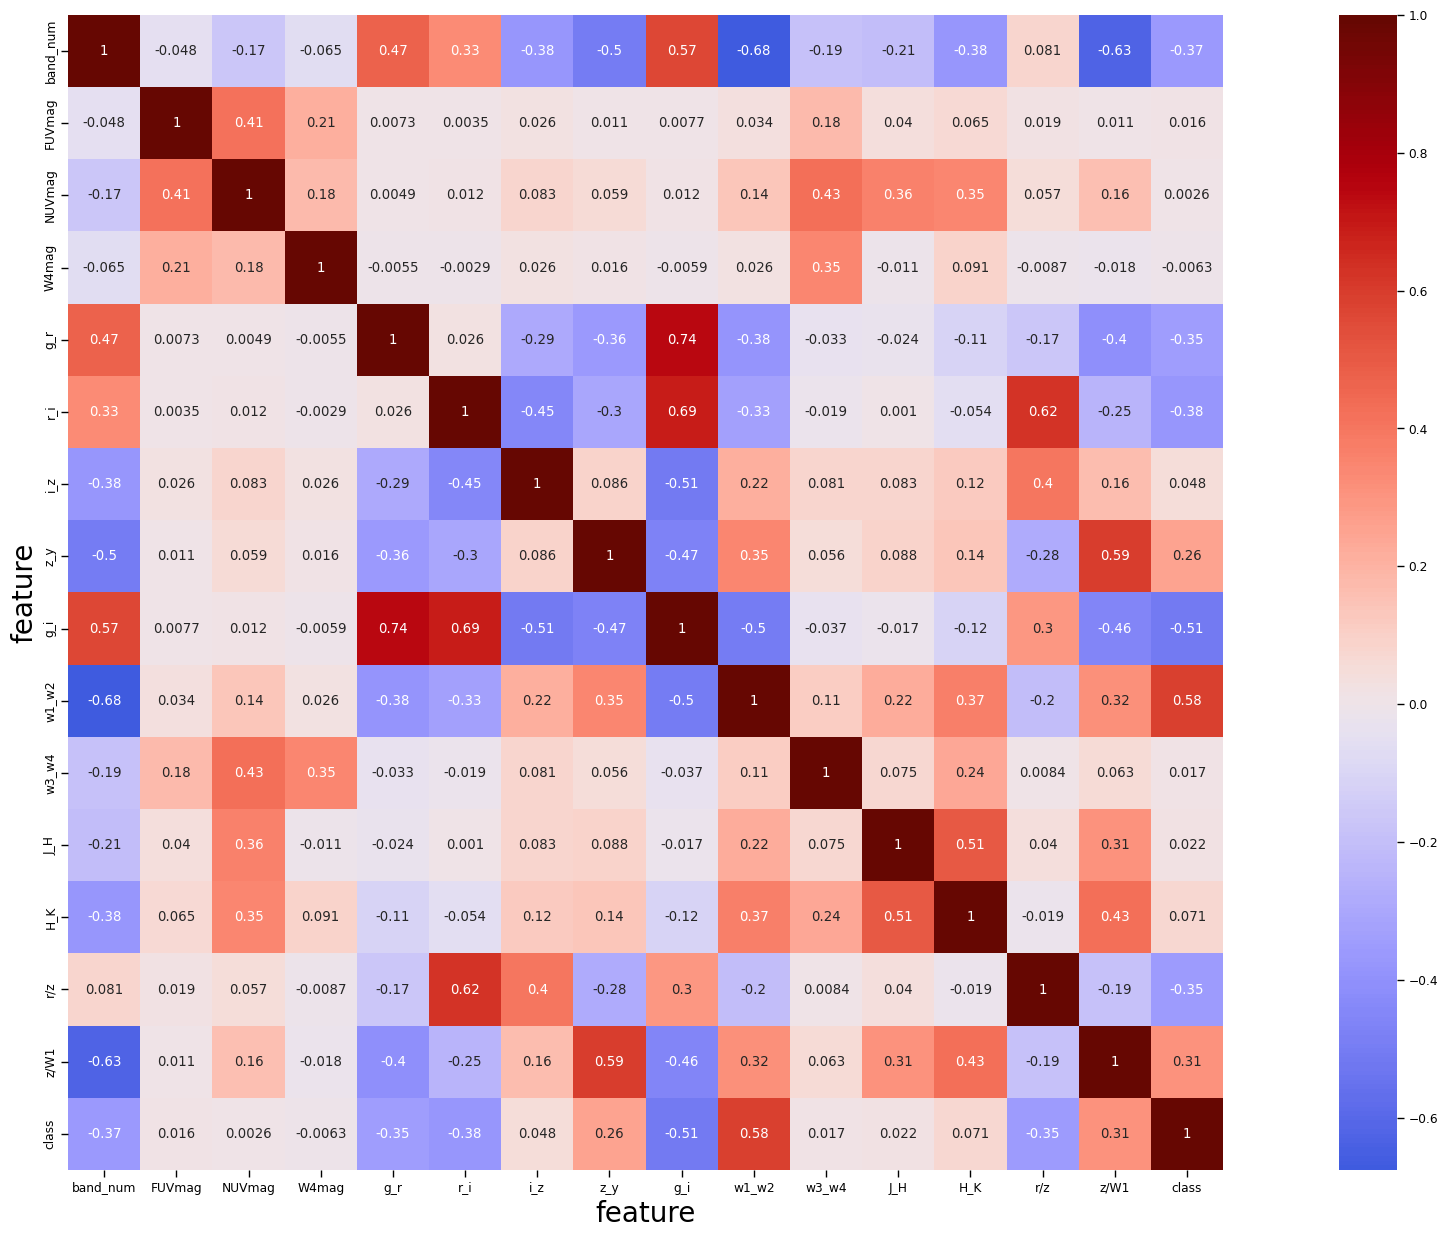

In [63]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [64]:
# norm_train_test_discard.loc[:, 'class'] = norm_train_test_discard.loc[:, 'class'].astype(bool)

In [65]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [66]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUVmag    FUVmag      1.000000
r_i       g_i         0.561323
band_num  g_i         0.493028
class     band_num    0.444838
i_z       g_i         0.437219
r/z       g_i         0.425859
i_z       z_y         0.388882
z/W1      z_y         0.375098
band_num  z/W1        0.372118
          i_z         0.363942
r/z       z_y         0.352461
band_num  z_y         0.348884
g_r       g_i         0.337430
r/z       i_z         0.321290
          r_i         0.313878
z/W1      band_num    0.293885
J_H       H_K         0.291668
z/W1      w1_w2       0.287300
band_num  w1_w2       0.280208
z_y       z/W1        0.274591
dtype: float64

In [67]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [68]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [69]:
target_feat = 'class'

In [70]:
list_drop_pps = []

In [71]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [72]:
list_drop_pps

[]

In [73]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [74]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'class', random_seed=seed)

In [75]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,w1_w2,class,0.207858,regression,True,mean absolute error,0.146057,0.115698,DecisionTreeRegressor()
1,band_num,class,0.150394,regression,True,mean absolute error,0.146057,0.124091,DecisionTreeRegressor()
2,r/z,class,0.100996,regression,True,mean absolute error,0.146057,0.131305,DecisionTreeRegressor()
3,g_i,class,0.088043,regression,True,mean absolute error,0.146057,0.133197,DecisionTreeRegressor()
4,z_y,class,0.067503,regression,True,mean absolute error,0.146057,0.136197,DecisionTreeRegressor()
5,r_i,class,0.040319,regression,True,mean absolute error,0.146057,0.140168,DecisionTreeRegressor()
6,i_z,class,0.033793,regression,True,mean absolute error,0.146057,0.141121,DecisionTreeRegressor()
7,FUVmag,class,0.000000,regression,True,mean absolute error,0.146057,0.166644,DecisionTreeRegressor()
8,NUVmag,class,0.000000,regression,True,mean absolute error,0.146057,0.166496,DecisionTreeRegressor()
9,W4mag,class,0.000000,regression,True,mean absolute error,0.146057,0.166869,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [76]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
final_feats = ['band_num', 'NUVmag', 'g_r', 'r_i', 'i_z', 'z_y',\
               'g_i', 'w1_w2', 'w3_w4', 'H_K', 'r/z', 'z/W1']  # After Boruta

In [77]:
feats_2_discard = list_drop_corr + list_drop_pps + ['FUVmag', 'W4mag', 'J_H']

Boruta discards one feature.

In [78]:
exp_AGN = pyr.setup(data=train_test_df, target='class', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu='force')  # 1 minute with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,class
2,Original Data,"(5383717, 39)"
3,Missing Values,False
4,Numeric Features,12
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(3768601, 12)"


In [79]:
pyr.get_config('X').columns

Index(['band_num', 'NUVmag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2',
       'w3_w4', 'H_K', 'r/z', 'z/W1'],
      dtype='object')

In [80]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,cuml.linear_model.linear_regression.LinearRegr...,True
lasso,Lasso Regression,cuml.linear_model.lasso.Lasso,True
ridge,Ridge Regression,cuml.linear_model.ridge.Ridge,True
en,Elastic Net,cuml.linear_model.elastic_net.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [81]:
pyr.add_metric('mad', 'MAD', mad, greater_is_better=False)

Name                                                       MAD
Display Name                                               MAD
Score Function                <function mad at 0x7f39aa7844c0>
Scorer               make_scorer(mad, greater_is_better=False)
Target                                                    pred
Args                                                        {}
Greater is Better                                        False
Custom                                                    True
Name: mad, dtype: object

In [82]:
used_models_reg      = ['catboost', 'lightgbm', 'xgboost', 'gbr', 'et', 'rf', 'dt', 'ridge', 'lr', 'dummy']  # knn too slow, ridge does not work
used_models_reg_gpu  = ['catboost', 'lightgbm', 'xgboost', 'lr', 'lasso', 'ridge', 'en', 'rf', 'dummy']
# final_selection_reg  = ['xgboost', 'rf', 'catboost', 'lightgbm', 'lr', 'dummy']  # 'rf' takes too much time
final_selection_reg  = ['xgboost', 'catboost', 'lightgbm', 'lr', 'ridge', 'dummy']
n_models             = 5
top_model_AGN = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort='RMSE')  # 1:15 hour for used_models_clf
# top_model_AGN = pyr.compare_models(n_select=n_models, exclude=['knn'], sort='RMSE')  # 1 hour, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,MAD,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0253,0.0028,0.0531,0.9380,0.0378,0.2232,0.0036,2.0450
catboost,CatBoost Regressor,0.0276,0.0032,0.0567,0.9295,0.0402,0.2278,0.0039,17.6010
lightgbm,Light Gradient Boosting Machine,0.0298,0.0037,0.0605,0.9195,0.0431,0.2506,0.0042,4.8170
lr,Linear Regression,0.0945,0.0253,0.1590,0.4446,0.1134,1.6242,0.0277,0.2200
ridge,Ridge Regression,0.0945,0.0253,0.1590,0.4446,0.1134,1.6242,0.0277,0.1390
dummy,Dummy Regressor,0.1659,0.0456,0.2134,-0.0000,0.1591,3.5199,0.0742,0.0950


Results from `compare_models` are with ad-hoc imputation are:  

|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9979  |0.9876|0.6146|0.8104|0.6989|0.6979|0.7047|92.2400 |

Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [83]:
stacked_model_AGN = pyr.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0])

,MAE,MSE,RMSE,R2,RMSLE,MAPE,MAD
Fold,,,,,,,
0,0.0202,0.0022,0.0466,0.9524,0.0331,0.1361,0.0022
1,0.0359,0.0027,0.0519,0.9408,0.0366,0.1694,0.0331
2,0.0204,0.0021,0.0462,0.9532,0.0329,0.1359,0.0021
3,0.0205,0.0022,0.0469,0.9516,0.0333,0.1367,0.0026
4,0.0204,0.0022,0.0469,0.9518,0.0334,0.1378,0.0022
5,0.0206,0.0022,0.0473,0.9509,0.0336,0.1359,0.0022
6,0.0206,0.0022,0.0466,0.9523,0.0332,0.1380,0.0021
7,0.0202,0.0021,0.0464,0.9529,0.0329,0.1359,0.0021
8,0.0205,0.0022,0.0469,0.9518,0.0333,0.1353,0.0026


In [84]:
tuned_AGN_reg = pyr.tune_model(stacked_model_AGN, early_stopping='asha', optimize='RMSE',\
                               search_library='tune-sklearn', search_algorithm='random')  # 20  minutes

,MAE,MSE,RMSE,R2,RMSLE,MAPE,MAD
Fold,,,,,,,
0,0.0223,0.0022,0.0470,0.9514,0.0338,0.2128,0.0098
1,0.0209,0.0021,0.0463,0.9529,0.0335,0.2090,0.0035
2,0.0209,0.0021,0.0463,0.9530,0.0334,0.2063,0.0026
3,0.0214,0.0022,0.0469,0.9517,0.0337,0.2126,0.0084
4,0.0205,0.0022,0.0467,0.9522,0.0337,0.2082,0.0026
5,0.0208,0.0022,0.0471,0.9512,0.0339,0.2118,0.0026
6,0.0213,0.0021,0.0463,0.9529,0.0334,0.2118,0.0057
7,0.0205,0.0022,0.0465,0.9527,0.0335,0.2130,0.0027
8,0.0205,0.0022,0.0468,0.9519,0.0337,0.2038,0.0026


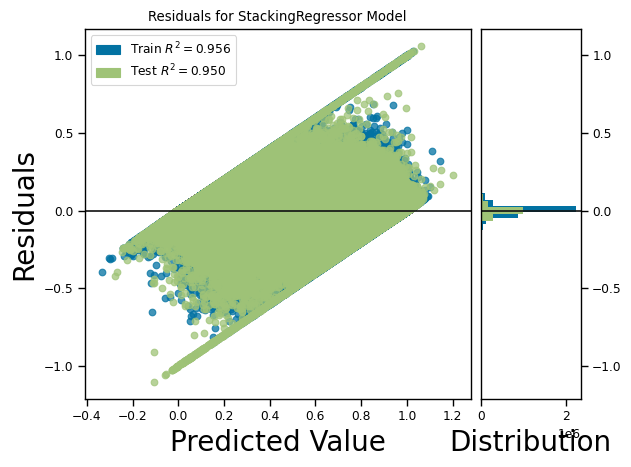

In [85]:
pyr.plot_model(tuned_AGN_reg, plot='residuals')

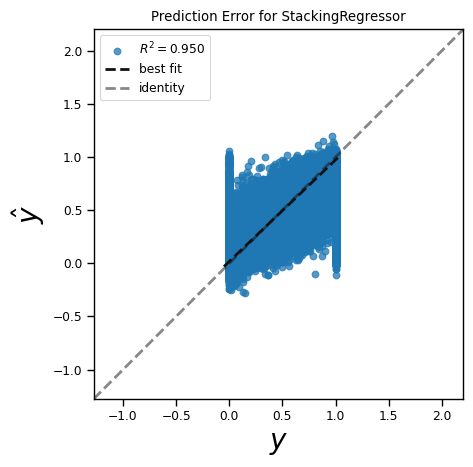

In [86]:
pyr.plot_model(tuned_AGN_reg, plot='error')

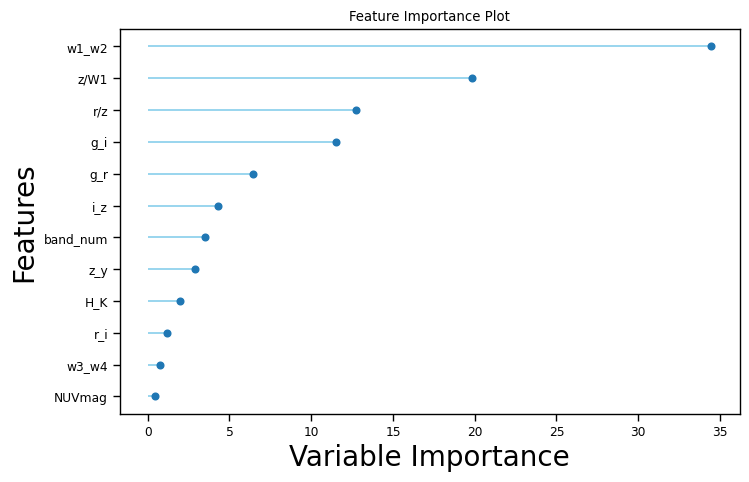

In [87]:
pyr.plot_model(tuned_AGN_reg.estimators_[0], plot='feature_all')

In [88]:
pyr.plot_model(tuned_AGN_reg, plot='parameter')

,Parameters
cv,5
estimators,"[('catboost', <catboost.core.CatBoostRegressor..."
final_estimator,"XGBRegressor(base_score=0.5, booster='gbtree',..."
n_jobs,1
passthrough,True
verbose,0


In [89]:
plt.rcParams.update(plt.rcParamsDefault)

In [90]:
pyr.predict_model(tuned_AGN_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,MAD
0,Stacking Regressor,0.0235,0.0023,0.0478,0.9498,0.0344,0.2127,0.0102


,band_num,NUVmag,g_r,r_i,i_z,z_y,g_i,w1_w2,w3_w4,H_K,r/z,z/W1,class,Label
0,0.947842,0.105469,-2.349921,2.159467,-1.236271,-0.841083,0.338716,-1.139824,0.087292,0.14925,1.187269,0.307920,0.8056,0.765121
1,1.324612,0.105469,1.163678,1.356437,-0.163889,-0.690534,1.610397,-1.650926,0.087292,0.14925,1.525919,-1.815785,0.3287,0.294704
2,-1.137560,0.105469,-0.440407,-0.413893,0.482484,0.515906,-0.620380,0.652730,0.087292,0.14925,-0.026778,0.401484,0.4613,0.461802
3,0.249080,0.105469,-0.440407,-0.413893,0.482484,0.515906,-0.620380,0.652730,0.087292,0.14925,-0.026778,0.401484,0.4620,0.436932
4,-1.137560,0.105469,-0.440407,-0.413893,0.482484,0.515906,-0.620380,0.652730,0.087292,0.14925,-0.026778,0.401484,0.4613,0.461802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615111,0.249080,0.105469,1.152404,0.128183,0.469179,-1.631022,0.946260,0.652730,0.087292,0.14925,0.499327,-0.892615,0.1607,0.247922
1615112,0.249080,0.105469,2.451880,0.153961,-0.399594,0.650959,1.803205,-1.380602,0.087292,0.14925,-0.114686,-0.859032,0.0221,0.065801
1615113,-1.137560,0.105469,-0.440407,-0.413893,0.482484,0.515906,-0.620380,0.652730,0.087292,0.14925,-0.026778,0.401484,0.4613,0.461802
1615114,1.324612,0.105469,0.685766,0.226079,-1.038957,2.552229,0.678468,-1.496659,0.087292,0.14925,-0.673239,-0.969512,0.1002,0.151946


In [91]:
test_prediction_reg = pyr.predict_model(tuned_AGN_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,MAD
0,Stacking Regressor,0.0235,0.0023,0.0478,0.9498,0.0344,0.2127,0.0102


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [92]:
final_AGN_reg = pyr.finalize_model(tuned_AGN_reg)

In [93]:
if save_model_flag:
    pyr.save_model(final_AGN_reg, 'models/classification_AGN_galaxy_apr_22_2022')  # Model (it will be saved with .pkl extension)
    # pyr.save_config('../../models/config_classification_AGN_galaxy_apr_22_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['W1mproPM', 'w2/w4',
                                                        'Hmag', 'w1/w3', 'i/K',
                                                        'FUV_NUV', 'Kmag',
                                                        'W2mproPM', 'J/K', 'r/H',
                                                        'zmag', 'W3mag', 'g/J',
                                                        'rmag', 'w1/w4', 'y/W2',
                                                        'FUV/K', 'ymag', 'gmag',
                                                        'Jmag', 'imag', 'w2_w3',
                                                        'i/y', 'FUVmag', 'W4mag',
                                                        'J_H'],
                                       id_

## Load Models

AGN detection model.

In [76]:
if load_model_flag:
    final_AGN_reg = pyr.load_model('models/classification_AGN_galaxy_apr_22_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [77]:
extended_data_AGN = validation_df.loc[:, get_final_column_names(final_AGN_reg, validation_df)].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
extended_cols_AGN = extended_data_AGN.columns.insert(0, 'catboost')
extended_cols_AGN = extended_cols_AGN.insert(0, 'lightgbm')
extended_cols_AGN = extended_cols_AGN.insert(0, 'lr')
extended_cols_AGN = extended_cols_AGN.insert(0, 'ridge')

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [78]:
print('Running data pre-processing:\n')
if isinstance(final_AGN_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_AGN_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [79]:
if isinstance(final_AGN_reg, sklearn.pipeline.Pipeline):
    importances_coef = final_AGN_reg.named_steps['trained_model'].final_estimator_.feature_importances_
else:
    importances_coef = final_AGN_reg.final_estimator_.feature_importances_

coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [80]:
if isinstance(final_AGN_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_AGN_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_AGN_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_AGN_reg.estimators
    estimators_list_ = final_AGN_reg.estimators_

In [81]:
base_models_names = [model[0] for model in estimators_list]

In [82]:
coef_sorted_base_df = {}

In [83]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_AGN.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                     'Importance': np.abs(model_fit.coef_) *\
                                     extended_data_AGN_df.loc[:, extended_cols_AGN.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_AGN.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [84]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [85]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for catboost...
Calculating for lightgbm...
Calculating for lr...
Calculating for ridge...


catboost             lightgbm                   lr                ridge  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      w1_w2  32.986107      z/W1  19.866667     w1_w2  26.387648     w1_w2   
1       z/W1  19.720854     w1_w2  18.433333       g_i  22.337275       g_i   
2        r/z  13.019848       r/z  10.166667       r/z   9.801033       r/z   
3        g_i  11.053946  band_num  10.033333      z/W1   9.110441      z/W1   
4        g_r   7.241155       g_r   8.500000       z_y   7.417839       z_y   
5        i_z   4.191453       z_y   7.900000       i_z   6.177800       i_z   
6   band_num   3.705945       g_i   7.700000  band_num   5.070766  band_num   
7        z_y   3.547390       i_z   6.633333       H_K   4.963253       H_K   
8        H_K   2.046282       r_i   4.766667       r_i   4.712332       r_i   
9        r_i   1.271951       H_K   2.666667    NUVmag   2.379787    NUVmag   
10     w3_w4   0.743540     w3_w4   2.366667       g_r   1.478630       g_r   
11    NUVmag   0.471529    NUVmag   0.966667     w3_w4   0.163196     w3_w4   

               
   Importance  
0   26.389634  
1   22.336330  
2    9.800993  
3    9.111162  
4    7.418449  
5    6.179006  
6    5.070903  
7    4.963623  
8    4.709911  
9    2.379985  
10   1.476790  
11   0.163215

In [86]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,ridge,52.404701
1,lr,23.283199
2,catboost,8.319914
3,lightgbm,2.199219
4,H_K,1.809855
5,w3_w4,1.720487
6,w1_w2,1.648594
7,band_num,1.496701
8,z/W1,1.220994
9,g_i,0.972524


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
learning algorithm does not provide feature importance.


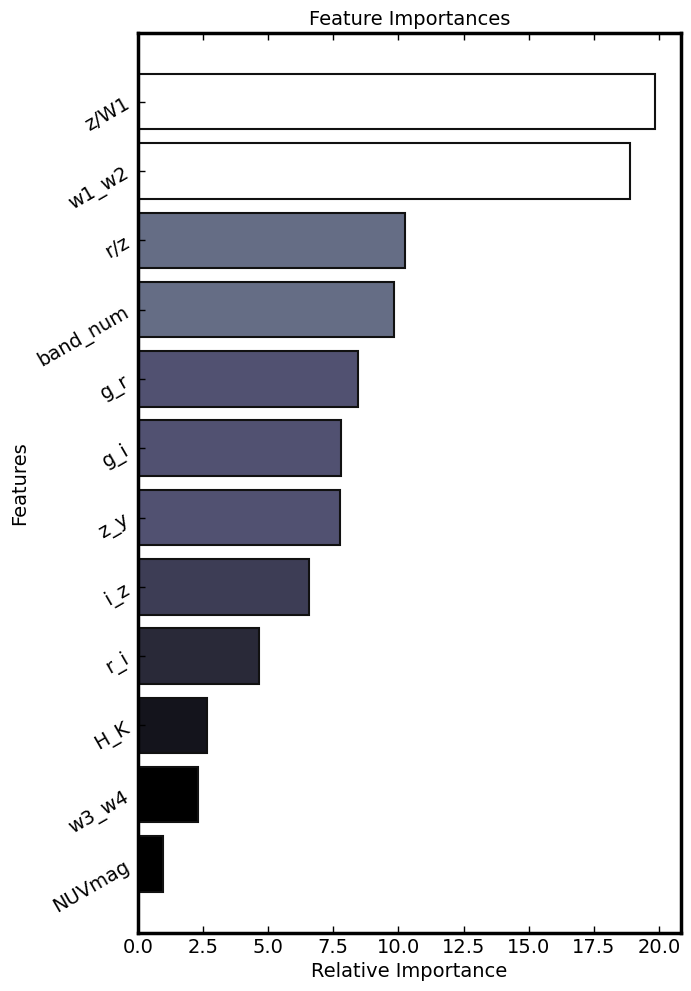

In [87]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_AGN_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('plots/feat_imp_classification_AGN_galaxy_03.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [88]:
AGN_pred_threshold = 0.5
# AGN_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [89]:
validation_prediction_reg = pyr.predict_model(final_AGN_reg, data=validation_df)

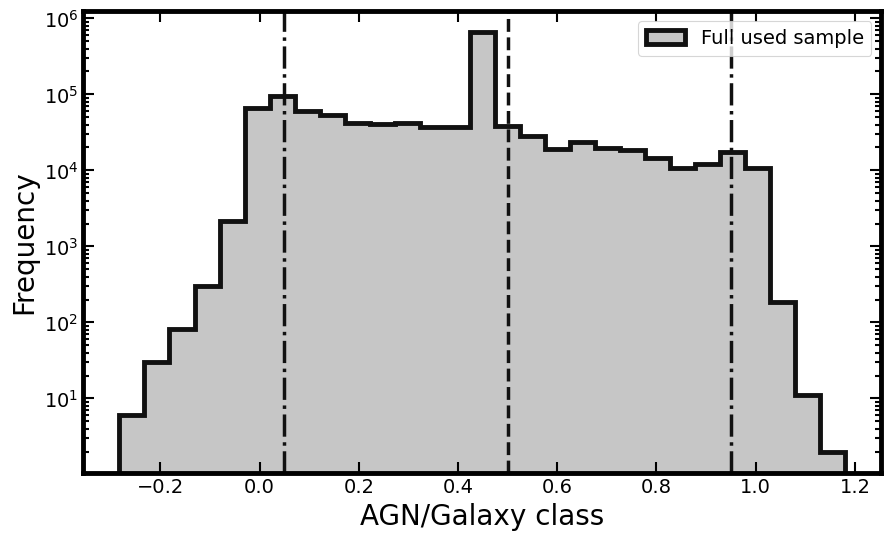

In [91]:
fig             = plt.figure(figsize=(9,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(validation_prediction_reg.loc[:, 'Label'])
max_score  = np.nanmax(validation_prediction_reg.loc[:, 'Label'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Full used sample')

ax1.axvline(x=0.5,           ls='--', c='k', lw=2.5)
ax1.axvline(x=gal_threshold, ls='-.', c='k', lw=2.5)
ax1.axvline(x=AGN_threshold, ls='-.', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig('plots/classes_AGN_galaxy_predictions_validation_03.pdf', bbox_inches='tight')
fig.tight_layout()

---

### Translate regression to classes

In [92]:
validation_prediction_reg['Pred_Class'] = 0
validation_prediction_reg.loc[:, 'Pred_Class'] = validation_prediction_reg.loc[:, 'Pred_Class'].mask((validation_prediction_reg.loc[:, 'Label'] >= 0.5), 1)
validation_prediction_reg.loc[:, 'Pred_Class'] = validation_prediction_reg.loc[:, 'Pred_Class'].astype(int)

In [93]:
validation_prediction_reg['Orig_Class'] = 0
validation_prediction_reg.loc[:, 'Orig_Class'] = validation_prediction_reg['Orig_Class'].mask((validation_prediction_reg.loc[:, 'class'] >= 0.5), 1)
validation_prediction_reg.loc[:, 'Orig_Class'] = validation_prediction_reg.loc[:, 'Orig_Class'].astype(int)

#### Move all probabilities > 1 and < 0 to their limits

In [94]:
validation_prediction_reg['Norm_Label']        = validation_prediction_reg.loc[:, 'Label'].copy()
validation_prediction_reg.loc[:, 'Norm_Label'] = validation_prediction_reg.loc[:, 'Norm_Label'].mask((validation_prediction_reg.loc[:, 'Norm_Label'] > 1), 1)
validation_prediction_reg.loc[:, 'Norm_Label'] = validation_prediction_reg.loc[:, 'Norm_Label'].mask((validation_prediction_reg.loc[:, 'Norm_Label'] < 0), 0)

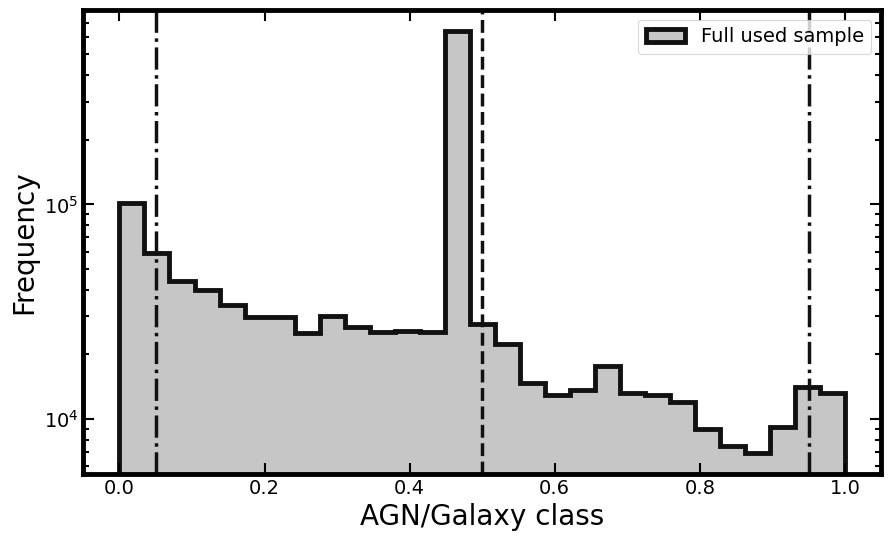

In [95]:
fig             = plt.figure(figsize=(9,5.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(validation_prediction_reg.loc[:, 'Norm_Label'])
max_score  = np.nanmax(validation_prediction_reg.loc[:, 'Norm_Label'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(validation_prediction_reg.loc[:, 'Norm_Label'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Full used sample')

ax1.axvline(x=0.5,           ls='--', c='k', lw=2.5)
ax1.axvline(x=gal_threshold, ls='-.', c='k', lw=2.5)
ax1.axvline(x=AGN_threshold, ls='-.', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('AGN/Galaxy class', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
if save_plot_flag:
    plt.savefig('plots/normalised_classes_AGN_galaxy_predictions_validation_03.pdf', bbox_inches='tight')
fig.tight_layout()

### Create confusion matrix with validation data.

In [96]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_reg['Orig_Class'] == 0) & np.array(validation_prediction_reg['Pred_Class'] == 0)),\
                        np.sum(np.array(validation_prediction_reg['Orig_Class'] == 0) & np.array(validation_prediction_reg['Pred_Class'] == 1))],\
                       [np.sum(np.array(validation_prediction_reg['Orig_Class'] == 1) & np.array(validation_prediction_reg['Pred_Class'] == 0)),\
                        np.sum(np.array(validation_prediction_reg['Orig_Class'] == 1) & np.array(validation_prediction_reg['Pred_Class'] == 1))]])

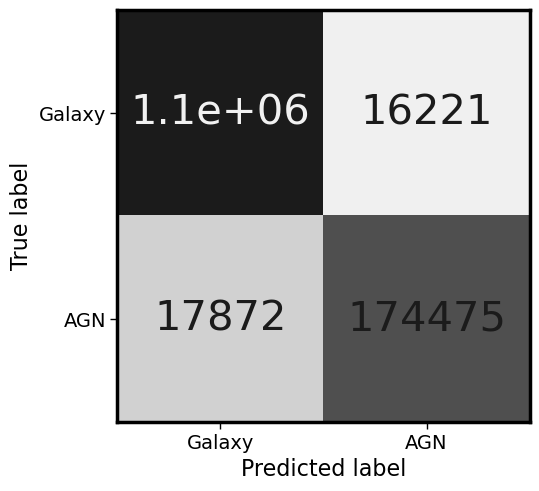

In [97]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_val,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_validation_classification_AGN_galaxy_03.pdf', bbox_inches='tight')
plt.show()

In [98]:
TN_AGN, FP_AGN, FN_AGN, TP_AGN = cm_mat_val.flatten().astype('float32')

In [99]:
MCC_AGN_val = ((TP_AGN * TN_AGN) - (FP_AGN * FN_AGN)) /\
            np.sqrt((TP_AGN + FP_AGN) * (TP_AGN + FN_AGN) * (TN_AGN + FP_AGN) * (TN_AGN + FN_AGN))

ACC_AGN_val = (TP_AGN + TN_AGN) / (TP_AGN + TN_AGN + FP_AGN + FN_AGN)

F1_AGN_val  = 2 * TP_AGN / (2 * TP_AGN + FP_AGN + FN_AGN)

Recall_AGN_val = TP_AGN / (TP_AGN + FN_AGN)

In [100]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.8962
Accuracy is ACC = 0.9747
F1-score is F1 = 0.9110
Recall is TPR = 0.9071


Create confusion matrix for original (v01) validation set.

In [101]:
orig_validation_prediction_reg = validation_prediction_reg.loc[old_validation_idx]

In [102]:
cm_mat_orig_val = np.array([[np.sum(np.array(orig_validation_prediction_reg['Orig_Class'] == 0) & np.array(orig_validation_prediction_reg['Pred_Class'] == 0)),\
                             np.sum(np.array(orig_validation_prediction_reg['Orig_Class'] == 0) & np.array(orig_validation_prediction_reg['Pred_Class'] == 1))],\
                            [np.sum(np.array(orig_validation_prediction_reg['Orig_Class'] == 1) & np.array(orig_validation_prediction_reg['Pred_Class'] == 0)),\
                             np.sum(np.array(orig_validation_prediction_reg['Orig_Class'] == 1) & np.array(orig_validation_prediction_reg['Pred_Class'] == 1))]])

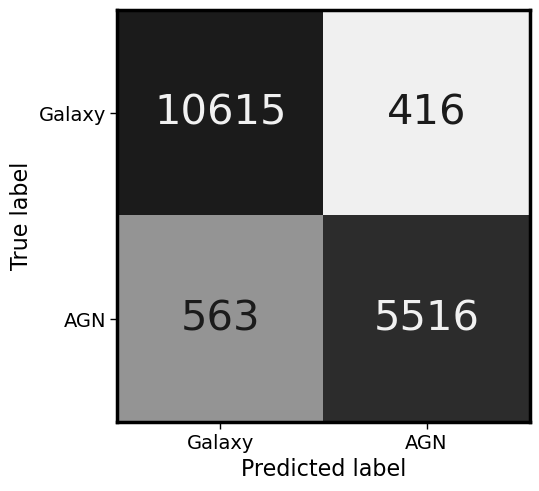

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_orig_val,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_original_validation_classification_AGN_galaxy_03.pdf', bbox_inches='tight')
plt.show()

In [104]:
TN_AGN_orig_val, FP_AGN_orig_val, FN_AGN_orig_val, TP_AGN_orig_val = cm_mat_orig_val.flatten().astype('float32')

In [105]:
MCC_AGN_orig_val = ((TP_AGN_orig_val * TN_AGN_orig_val) - (FP_AGN_orig_val * FN_AGN_orig_val)) /\
            np.sqrt((TP_AGN_orig_val + FP_AGN_orig_val) * (TP_AGN_orig_val + FN_AGN_orig_val) * (TN_AGN_orig_val + FP_AGN_orig_val) * (TN_AGN_orig_val + FN_AGN_orig_val))

ACC_AGN_orig_val = (TP_AGN_orig_val + TN_AGN_orig_val) / (TP_AGN_orig_val + TN_AGN_orig_val + FP_AGN_orig_val + FN_AGN_orig_val)

F1_AGN_orig_val  = 2 * TP_AGN_orig_val / (2 * TP_AGN_orig_val + FP_AGN_orig_val + FN_AGN_orig_val)

Recall_AGN_orig_val = TP_AGN_orig_val / (TP_AGN_orig_val + FN_AGN_orig_val)

In [106]:
print('Metrics for the original Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_orig_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_orig_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_orig_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_orig_val:.4f}')

Metrics for the original Validation set.
Matthews Correlation Coefficient is MCC = 0.8746
Accuracy is ACC = 0.9428
F1-score is F1 = 0.9185
Recall is TPR = 0.9074


In [107]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            train_test_df.drop(columns=['class']), train_test_df.loc[:, 'class'], False, 'class'
        )

X_train, X_test, y_train, y_test = train_test_split(
                train_test_df.drop(columns=['class']),
                train_test_df.loc[:, 'class'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [108]:
train_prediction_reg = pyr.predict_model(final_AGN_reg, data=train_data_df)

In [109]:
test_prediction_reg = pyr.predict_model(final_AGN_reg, data=test_data_df)

In [110]:
train_prediction_reg['Pred_Class']        = 0
train_prediction_reg.loc[:, 'Pred_Class'] = train_prediction_reg.loc[:, 'Pred_Class'].mask((train_prediction_reg.loc[:, 'Label'] >= 0.5), 1)
train_prediction_reg.loc[:, 'Pred_Class'] = train_prediction_reg.loc[:, 'Pred_Class'].astype(int)

In [111]:
train_prediction_reg['Orig_Class']        = 0
train_prediction_reg.loc[:, 'Orig_Class'] = train_prediction_reg['Orig_Class'].mask((train_prediction_reg.loc[:, 'class'] >= 0.5), 1)
train_prediction_reg.loc[:, 'Orig_Class'] = train_prediction_reg.loc[:, 'Orig_Class'].astype(int)

In [112]:
test_prediction_reg['Pred_Class']         = 0
test_prediction_reg.loc[:, 'Pred_Class']  = test_prediction_reg.loc[:, 'Pred_Class'].mask((test_prediction_reg.loc[:, 'Label'] >= 0.5), 1)
test_prediction_reg.loc[:, 'Pred_Class']  = test_prediction_reg.loc[:, 'Pred_Class'].astype(int)

In [113]:
test_prediction_reg['Orig_Class']         = 0
test_prediction_reg.loc[:, 'Orig_Class']  = test_prediction_reg['Orig_Class'].mask((test_prediction_reg.loc[:, 'class'] >= 0.5), 1)
test_prediction_reg.loc[:, 'Orig_Class']  = test_prediction_reg.loc[:, 'Orig_Class'].astype(int)

In [114]:
train_prediction_reg['Norm_Label']        = train_prediction_reg.loc[:, 'Label'].copy()
train_prediction_reg.loc[:, 'Norm_Label'] = train_prediction_reg.loc[:, 'Norm_Label'].mask((train_prediction_reg.loc[:, 'Norm_Label'] > 1), 1)
train_prediction_reg.loc[:, 'Norm_Label'] = train_prediction_reg.loc[:, 'Norm_Label'].mask((train_prediction_reg.loc[:, 'Norm_Label'] < 0), 0)

In [115]:
test_prediction_reg['Norm_Label']         = test_prediction_reg.loc[:, 'Label'].copy()
test_prediction_reg.loc[:, 'Norm_Label']  = test_prediction_reg.loc[:, 'Norm_Label'].mask((test_prediction_reg.loc[:, 'Norm_Label'] > 1), 1)
test_prediction_reg.loc[:, 'Norm_Label']  = test_prediction_reg.loc[:, 'Norm_Label'].mask((test_prediction_reg.loc[:, 'Norm_Label'] < 0), 0)

In [116]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_reg['Orig_Class'] == 0) & np.array(train_prediction_reg['Pred_Class'] == 0)),\
                          np.sum(np.array(train_prediction_reg['Orig_Class'] == 0) & np.array(train_prediction_reg['Pred_Class'] == 1))],\
                         [np.sum(np.array(train_prediction_reg['Orig_Class'] == 1) & np.array(train_prediction_reg['Pred_Class'] == 0)),\
                          np.sum(np.array(train_prediction_reg['Orig_Class'] == 1) & np.array(train_prediction_reg['Pred_Class'] == 1))]])

In [117]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_reg['Orig_Class'] == 0) & np.array(test_prediction_reg['Pred_Class'] == 0)),\
                         np.sum(np.array(test_prediction_reg['Orig_Class'] == 0) & np.array(test_prediction_reg['Pred_Class'] == 1))],\
                        [np.sum(np.array(test_prediction_reg['Orig_Class'] == 1) & np.array(test_prediction_reg['Pred_Class'] == 0)),\
                         np.sum(np.array(test_prediction_reg['Orig_Class'] == 1) & np.array(test_prediction_reg['Pred_Class'] == 1))]])

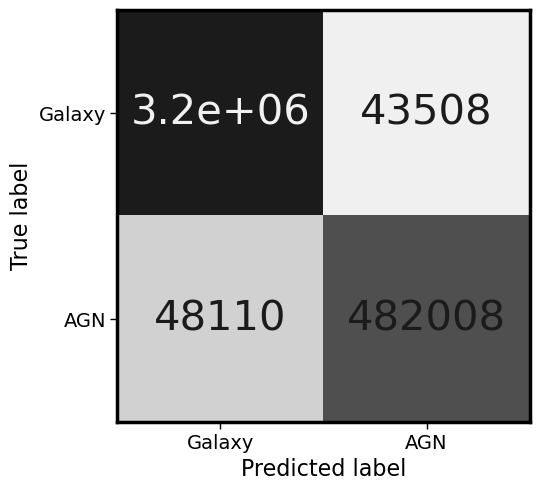

In [118]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_train,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_train_classification_AGN_galaxy_03.pdf', bbox_inches='tight')
plt.show()

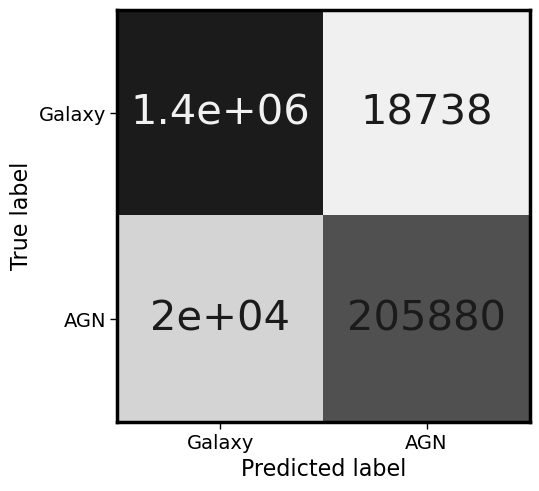

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_test,
                              display_labels=['Galaxy', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('plots/conf_matrix_test_classification_AGN_galaxy_03.pdf', bbox_inches='tight')
plt.show()

In [120]:
TN_AGN_train, FP_AGN_train, FN_AGN_train, TP_AGN_train = cm_mat_train.flatten().astype('float32')

In [121]:
MCC_AGN_train = ((TP_AGN_train * TN_AGN_train) - (FP_AGN_train * FN_AGN_train)) /\
            np.sqrt((TP_AGN_train + FP_AGN_train) * (TP_AGN_train + FN_AGN_train) * 
                    (TN_AGN_train + FP_AGN_train) * (TN_AGN_train + FN_AGN_train))

ACC_AGN_train = (TP_AGN_train + TN_AGN_train) / (TP_AGN_train + TN_AGN_train + FP_AGN_train + FN_AGN_train)

F1_AGN_train  = 2 * TP_AGN_train / (2 * TP_AGN_train + FP_AGN_train + FN_AGN_train)

Recall_AGN_train = TP_AGN_train / (TP_AGN_train + FN_AGN_train)

In [122]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_train:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_train:.4f}')
print(f'F1-score is F1 = {F1_AGN_train:.4f}')
print(f'Recall is TPR = {Recall_AGN_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.8991
Accuracy is ACC = 0.9757
F1-score is F1 = 0.9132
Recall is TPR = 0.9092


In [123]:
TN_AGN_test, FP_AGN_test, FN_AGN_test, TP_AGN_test = cm_mat_test.flatten().astype('float32')

In [124]:
MCC_AGN_test = ((TP_AGN_test * TN_AGN_test) - (FP_AGN_test * FN_AGN_test)) /\
            np.sqrt((TP_AGN_test + FP_AGN_test) * (TP_AGN_test + FN_AGN_test) * 
                    (TN_AGN_test + FP_AGN_test) * (TN_AGN_test + FN_AGN_test))

ACC_AGN_test = (TP_AGN_test + TN_AGN_test) / (TP_AGN_test + TN_AGN_test + FP_AGN_test + FN_AGN_test)

F1_AGN_test  = 2 * TP_AGN_test / (2 * TP_AGN_test + FP_AGN_test + FN_AGN_test)

Recall_AGN_test = TP_AGN_test / (TP_AGN_test + FN_AGN_test)

In [125]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_test:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_test:.4f}')
print(f'F1-score is F1 = {F1_AGN_test:.4f}')
print(f'Recall is TPR = {Recall_AGN_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.8990
Accuracy is ACC = 0.9757
F1-score is F1 = 0.9131
Recall is TPR = 0.9096


### Calculate ROC AUC values and plots.

In [126]:
roc_auc_train      = roc_auc_score(train_prediction_reg.loc[:, 'Orig_Class'],      train_prediction_reg.loc[:, 'Norm_Label'])
roc_auc_test       = roc_auc_score(test_prediction_reg.loc[:, 'Orig_Class'],       test_prediction_reg.loc[:, 'Norm_Label'])
roc_auc_validation = roc_auc_score(validation_prediction_reg.loc[:, 'Orig_Class'], validation_prediction_reg.loc[:, 'Norm_Label'])

In [127]:
print(f'Area under the curve (ROC) for training   = {roc_auc_train:.5f}')
print(f'Area under the curve (ROC) for test       = {roc_auc_test:.5f}')
print(f'Area under the curve (ROC) for validation = {roc_auc_validation:.5f}')

Area under the curve (ROC) for training   = 0.97268
Area under the curve (ROC) for test       = 0.97306
Area under the curve (ROC) for validation = 0.96984


In [128]:
fpr_train, tpr_train, thresh_train = roc_curve(train_prediction_reg.loc[:, 'Orig_Class'],      train_prediction_reg.loc[:, 'Norm_Label'])
fpr_test,  tpr_test,  thresh_test  = roc_curve(test_prediction_reg.loc[:, 'Orig_Class'],       test_prediction_reg.loc[:, 'Norm_Label'])
fpr_val,   tpr_val,   thresh_val   = roc_curve(validation_prediction_reg.loc[:, 'Orig_Class'], validation_prediction_reg.loc[:, 'Norm_Label'])

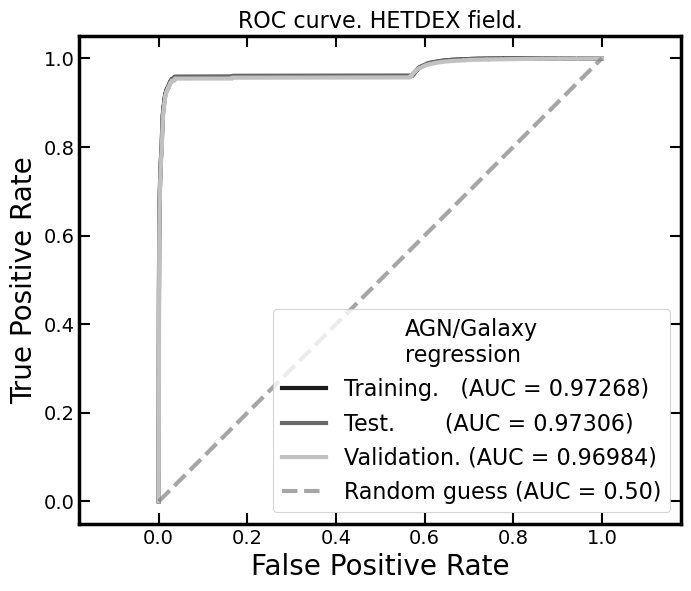

In [129]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

viz_train = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train)
viz_test  = RocCurveDisplay(fpr=fpr_test,  tpr=tpr_test,  roc_auc=roc_auc_test)
viz_val   = RocCurveDisplay(fpr=fpr_val,   tpr=tpr_val,   roc_auc=roc_auc_validation)
viz_train.plot(ax=ax1, lw=3, c=cm.get_cmap('cet_dimgray')(0.0), label=f"Training.   (AUC = {roc_auc_train:0.5f})")
viz_test.plot(ax=ax1,  lw=3, c=cm.get_cmap('cet_dimgray')(0.4), label=f"Test.       (AUC = {roc_auc_test:0.5f})")
viz_val.plot(ax=ax1,   lw=3, c=cm.get_cmap('cet_dimgray')(0.8), label=f"Validation. (AUC = {roc_auc_validation:0.5f})")

ax1.plot([0, 1], [0, 1], ls='--', marker=None, c='Gray', alpha=0.7, lw=3.0, label='Random guess (AUC = 0.50)')

ax1.set_xlabel('False Positive Rate', fontsize=20)
ax1.set_ylabel('True Positive Rate', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
# ax1.set_aspect('equal', 'box')
plt.legend(loc=4, fontsize=16, title='AGN/Galaxy\nregression', title_fontsize=16)
ax1.set_aspect('equal', 'datalim')
ax1.set_title('ROC curve. HETDEX field.', fontsize=16)
fig.tight_layout()
if save_plot_flag:
    plt.savefig('plots/AUC_ROC_regression_AGN_galaxy_03.pdf', bbox_inches='tight')
plt.show()

### Probability calibration curve (validation)

In [130]:
fract_positiv_AGN, mean_pred_val_AGN =  calibration_curve(validation_prediction_reg.loc[:, 'Orig_Class'],\
                                                          validation_prediction_reg.loc[:, 'Norm_Label'],\
                                                          n_bins=20, normalize=False)  # calibration_curve(y_test, prob_pos, n_bins=10)

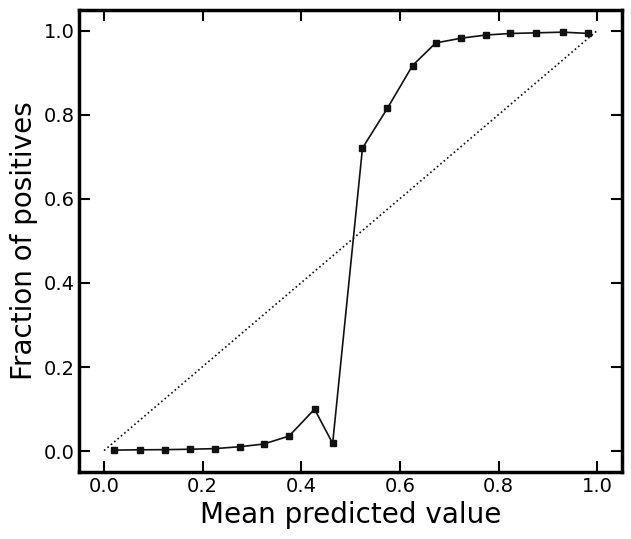

In [131]:
fig             = plt.figure(figsize=(7,6))
ax1             = fig.add_subplot(111)

ax1.plot(mean_pred_val_AGN, fract_positiv_AGN, ls='-', marker='s', c='k')
ax1.plot([0, 1], [0, 1], ls=':', c='k', label="Perfectly calibrated")
ax1.set_xlabel('Mean predicted value', fontsize=20)
ax1.set_ylabel('Fraction of positives', fontsize=20)
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.show()